In [1]:
import numpy as np
import pandas as pd


In [2]:
BIG_MODELS = ["meta-llama/Llama-3.2-3B", "google/gemma-2-2b"] +\
    ["allenai/OLMo-2-1124-7B", "allenai/OLMo-2-1124-13B", "google/gemma-2-9b"]

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.model_selection import LeaveOneOut

from sklearn.metrics import mean_absolute_error, mean_squared_error
import scipy

# Expert label to human subjects' category options
nonsense_labels_mapping = {
    "near": "inconceivable",
    "far": "inconceivable",
    "probable": "probable",
}

goulding_labels_mapping = {
    "impossible": "impossible",
    "possible": "possible",
    "improbable": "possible",
}

shades_labels_mapping = {
    "impossible": "impossible",
    "probable": "probable",
    "improbable": "improbable",
    "inconceivable": "inconceivable",
}

## Helper function to fit QDA Models to projections on modal difference vectors
def fit_qda(data, features, dataset):

    # Define dataset level attributes
    if dataset == "hu_shades/data":
        mapping = shades_labels_mapping
    elif dataset == "hu_nonsense/data":
        mapping = nonsense_labels_mapping
    elif dataset == "goulding/adults":
        mapping = goulding_labels_mapping
    else:
        raise ValueError()
        
    # Store results
    kl_divs = []
    maes = []
    mses = []
    model_entropies = []
    human_entropies = []
    model_class_probs = []
    human_class_probs = []
    sentences = []

    results_df = pd.DataFrame.from_dict({})

    # Compute metrics holding one stimulus out at a time
    for train_idxs, test_idxs in LeaveOneOut().split(data):
        train_data = data.iloc[train_idxs]
        test_data = data.iloc[test_idxs]

        labels = train_data["label"]
        train_features = train_data[features]

        # Fit QDA to standardardized expert labels
        scaler = StandardScaler().fit(train_features)
        train_features = scaler.transform(train_features)
        qda = QDA().fit(train_features, labels)
        
        ### Compare the human-subjects classification behavior to the predictions from the
        # generative model
        class_labels = list(set(mapping.values()))
        class_labels.sort()

        # Given trained QDA, see how it does predicting the held out data point
        sample_features = scaler.transform(test_data[features])
        # Predict probabilities for each QDA Gaussian class
        predicted_probabilities = qda.predict_proba(sample_features.reshape(1, -1))[0]

        # True probabilities drawn from human responses
        true_probabilites = np.array(
            [test_data.iloc[0][class_label] for class_label in class_labels]
        )

        # Process Predicted probabilities: Must sum probabilities from every
        # QDA class that goes into a human class. e.g., probable + improbable = possible
        consolidated_probabilities = np.zeros(len(true_probabilites))
        for pred_idx, cls in enumerate(qda.classes_):
            # mapping[cls] -> human response class
            # class_labels.index(mapping[cls]) -> Where in the "true_probabilities" distribution is this class?
            consolidated_probabilities[class_labels.index(mapping[cls])] += predicted_probabilities[pred_idx]

        # Asserts to ensure probabilities are computed correctly
        assert np.isclose(np.sum(true_probabilites), 1.0)
        assert np.isclose(np.sum(consolidated_probabilities), 1.0)

        if dataset in ["hu_nonsense/data", "goulding/adults"]:
            assert len(consolidated_probabilities) == 2
            assert len(true_probabilites) == 2
        else:
            assert len(consolidated_probabilities) == 4
            assert len(true_probabilites) == 4

        # Now, probabilities are consolidated and human judgements and model probabilies are of the same shape
        
        # Compute Metrics
        kl_div = np.sum(scipy.special.rel_entr(true_probabilites, consolidated_probabilities))
        mae = mean_absolute_error(true_probabilites, consolidated_probabilities)
        mse = mean_squared_error(true_probabilites, consolidated_probabilities)

        kl_divs.append(kl_div)
        maes.append(mae)
        mses.append(mse)

        model_entropies.append(scipy.stats.entropy(consolidated_probabilities))
        human_entropies.append(scipy.stats.entropy(true_probabilites))

        sentences.append(test_data.iloc[0]["sentence"])

        # For all datasets, pick out the first N-1 entries in the probability distribution.
        # These are independent, and will be flattened and correlated.
        model_class_probs.append(list(consolidated_probabilities)[:-1])
        human_class_probs.append(list(true_probabilites)[:-1])

    ### Save off data
    results_df["KL Div"] = kl_divs
    results_df["MAE"] = maes
    results_df["MSE"] = mses
    results_df["Model Entropies"] = model_entropies
    results_df["Human Entropies"] = human_entropies
    results_df["Model Class Probs"] = model_class_probs
    results_df["Human Class Probs"] = human_class_probs
    results_df["Sentence"] = sentences

    return results_df

In [5]:
# Run QDA analysis over all big models, featurizations, and datasets
import os
calibration_results = {
    "Model": [],
    "Dataset": [],
    "Condition": [],
    "MAE": [],
    "MSE": [],
    "KL": [],
    "Pearson R": [],
    "Entropy Correlation": [],
}

entropy_results = {
    "Model": [],
    "Dataset": [],
    "Condition": [],
    "Human Entropy": [],
    "Model Entropy": [],
    "Human Entropy Bucket": [],
}

dataset_map = {
    "hu_nonsense/data": "Hu et al. 2025a", 
    "hu_shades/data": "Hu et al. 2025b", 
    "goulding/adults": "Goulding"
}

for model in BIG_MODELS:
    for dataset in ["hu_nonsense/data", "hu_shades/data", "goulding/adults"]:
        for condition in ["Linear_Representation", "Probability", "PC", "Random"]:
            if condition == "Probability":
                features = ["Probability"]
            else:
                features = ["probable_improbable", "improbable_impossible", "impossible_inconceivable"]

            path = os.path.join("../results", model, "Calibration", dataset, f"{condition}.csv")
            data = pd.read_csv(path)
            data = fit_qda(data, features, dataset)

            # Store Calibration Results
            calibration_results["Model"].append(model)
            calibration_results["Dataset"].append(dataset_map[dataset])
            calibration_results["Condition"].append(condition)
            calibration_results["MAE"].append(data["MAE"].mean())
            calibration_results["MSE"].append(data["MSE"].mean())
            calibration_results["KL"].append(data["KL Div"].mean())

            human_probs = np.concat(data["Human Class Probs"], axis=0)
            model_probs = np.concat(data["Model Class Probs"], axis=0)

            calibration_results["Pearson R"].append(scipy.stats.pearsonr(human_probs, model_probs).statistic)
            calibration_results["Entropy Correlation"].append(scipy.stats.pearsonr(data["Model Entropies"], data["Human Entropies"]).statistic)

            # Store raw entropy results
            ent_threshold = data["Human Entropies"].quantile(0.5)
            top_half = list(data["Human Entropies"] > ent_threshold)

            entropy_results["Model"] += [model] * len(top_half)
            entropy_results["Dataset"] += [dataset_map[dataset]] * len(top_half)
            entropy_results["Condition"] += [condition] * len(top_half)
            entropy_results["Model Entropy"] += list(data["Model Entropies"])
            entropy_results["Human Entropy"] += list(data["Human Entropies"])
            entropy_results["Human Entropy Bucket"] += ["High" if top_bool else "Low" for top_bool in top_half]

calibration_results = pd.DataFrame.from_dict(calibration_results)
entropy_results = pd.DataFrame.from_dict(entropy_results)


/gpfs/data/epavlick/mlepori/miniconda3/envs/modal_features/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/gpfs/data/epavlick/mlepori/miniconda3/envs/modal_features/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/gpfs/data/epavlick/mlepori/miniconda3/envs/modal_features/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/gpfs/data/epavlick/mlepori/miniconda3/envs/modal_features/lib/python3.11/site-packages/sklearn/discriminant_analysis.

In [6]:
# Inspect DF
calibration_results.head()

,Model,Dataset,Condition,MAE,MSE,KL,Pearson R,Entropy Correlation
0,meta-llama/Llama-3.2-3B,Hu et al. 2025a,Linear_Representation,0.241019,0.111817,0.898390,0.612686,-0.095060
1,meta-llama/Llama-3.2-3B,Hu et al. 2025a,Probability,0.263477,0.122569,0.377332,0.451226,-0.025263
2,meta-llama/Llama-3.2-3B,Hu et al. 2025a,PC,0.307555,0.171030,0.991534,0.238612,-0.094924
3,meta-llama/Llama-3.2-3B,Hu et al. 2025a,Random,0.329342,0.189331,0.774743,0.058731,-0.139140
4,meta-llama/Llama-3.2-3B,Hu et al. 2025b,Linear_Representation,0.149665,0.056992,0.850680,0.727286,0.109125


In [7]:
# Inspect Entropy DF
entropy_results[entropy_results["Model"] == "google/gemma-2-9b"].head()

,Model,Dataset,Condition,Human Entropy,Model Entropy,Human Entropy Bucket
6416,google/gemma-2-9b,Hu et al. 2025a,Linear_Representation,0.000000,0.031922,Low
6417,google/gemma-2-9b,Hu et al. 2025a,Linear_Representation,0.636514,0.082251,High
6418,google/gemma-2-9b,Hu et al. 2025a,Linear_Representation,0.392674,0.015234,High
6419,google/gemma-2-9b,Hu et al. 2025a,Linear_Representation,0.000000,0.610656,Low
6420,google/gemma-2-9b,Hu et al. 2025a,Linear_Representation,0.598270,0.002068,High


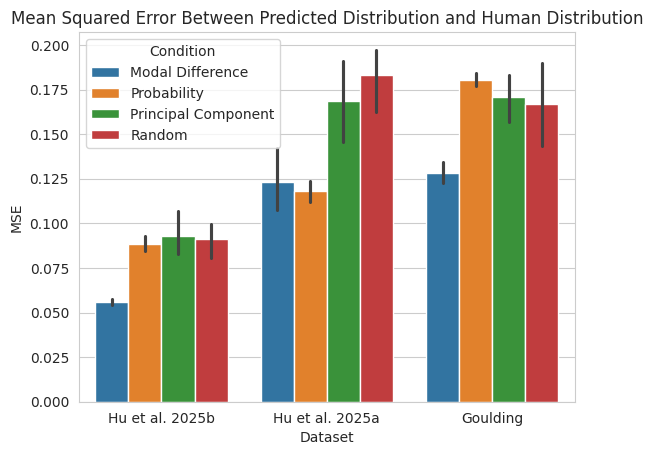

In [8]:
sns.set_style("whitegrid")
g = sns.barplot(data=calibration_results, x="Dataset", y="MSE", hue="Condition", order=["Hu et al. 2025b", "Hu et al. 2025a", "Goulding"])
g.get_legend().get_texts()[0].set_text('Modal Difference') 
g.get_legend().get_texts()[2].set_text('Principal Component') 
plt.title("Mean Squared Error Between Predicted Distribution and Human Distribution")
plt.savefig("../Figures/Study3_MSE.pdf", format="pdf", bbox_inches="tight")
plt.show()

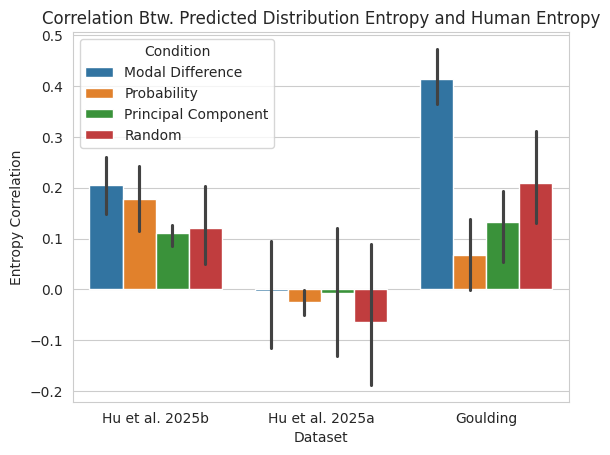

In [9]:
sns.set_style("whitegrid")
g = sns.barplot(data=calibration_results, x="Dataset", y="Entropy Correlation", hue="Condition", order=["Hu et al. 2025b", "Hu et al. 2025a", "Goulding"])
g.get_legend().get_texts()[0].set_text('Modal Difference') 
g.get_legend().get_texts()[2].set_text('Principal Component') 
plt.title("Correlation Btw. Predicted Distribution Entropy and Human Entropy")
plt.savefig("../Figures/Study3_Entropy_Correlation.pdf", format="pdf", bbox_inches="tight")
plt.show()

/tmp/ipykernel_3383111/929779553.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Modal Difference", "Probability", "Principal Component", "Random"], rotation=30)
/tmp/ipykernel_3383111/929779553.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Modal Difference", "Probability", "Principal Component", "Random"], rotation=30)
/tmp/ipykernel_3383111/929779553.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Modal Difference", "Probability", "Principal Component", "Random"], rotation=30)


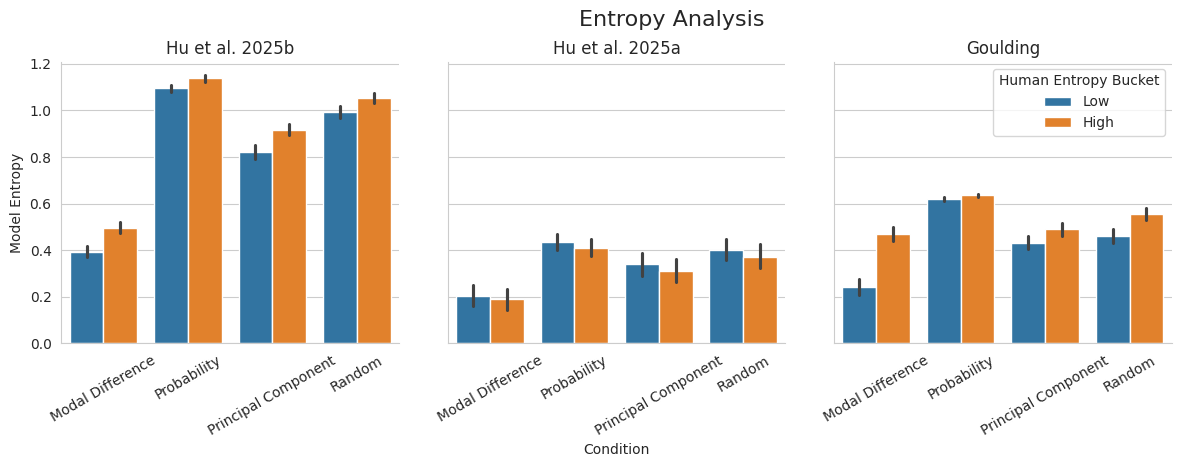

In [28]:
sns.set_style("whitegrid")
g = sns.catplot(data=entropy_results, x="Condition", y="Model Entropy", hue="Human Entropy Bucket", col="Dataset", kind="bar", col_order=["Hu et al. 2025b", "Hu et al. 2025a", "Goulding"], height=4, aspect=1)

for ax in g.axes.flat:
    title = ax.get_title()
    if "=" in title:
        new_title = title.split("=")[-1].strip()
        ax.set_title(new_title)
    ax.set_xlabel("")
    ax.set_xticklabels(["Modal Difference", "Probability", "Principal Component", "Random"], rotation=30)

middle_ax = g.axes.flat[1]
middle_ax.set_xlabel("Condition")

plt.suptitle("Entropy Analysis", fontsize=16)
plt.subplots_adjust(top=0.85)

# Deal with legend
ax = g.axes.flat[2]
handles = (g._legend_data.values())
labels = (g._legend_data.keys())

g._legend.remove()
ax.legend(handles, labels, title="Human Entropy Bucket", loc="upper right", frameon=True)

plt.ylim(bottom=0)
plt.savefig("../Figures/Study3_Entropy.pdf", format="pdf", bbox_inches="tight")
plt.show()

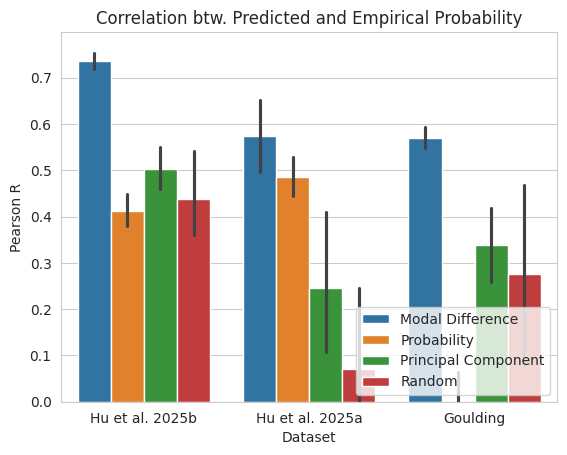

In [11]:

sns.set_style("whitegrid")
g = sns.barplot(data=calibration_results, x="Dataset", y="Pearson R", hue="Condition", order=["Hu et al. 2025b", "Hu et al. 2025a", "Goulding"])
plt.title("Correlation btw. Predicted and Empirical Probability")
plt.ylim(bottom=0)
plt.legend(loc="lower right")
g.get_legend().get_texts()[0].set_text('Modal Difference') 
g.get_legend().get_texts()[2].set_text('Principal Component') 
plt.savefig("../Figures/Study3_Correlation.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Inspect particular datasets for qualitative examples


In [12]:

features = ["probable_improbable", "improbable_impossible", "impossible_inconceivable"]
path = os.path.join("../results", "google/gemma-2-9b", "Calibration", "goulding/adults", "Linear_Representation.csv")
data = pd.read_csv(path)
data = fit_qda(data, features, "goulding/adults")

print("Linear Representation, Goulding")
for _, row in data.iterrows():
    print(row["Sentence"], 1-row["Model Class Probs"][0].item(), 1-row["Human Class Probs"][0].item())
        
features = ["Probability"]
path = os.path.join("../results", "google/gemma-2-9b", "Calibration", "goulding/adults", "Probability.csv")
data = pd.read_csv(path)
data = fit_qda(data, features, "goulding/adults")

print("Probability, Goulding")
for _, row in data.iterrows():
    print(row["Sentence"], 1-row["Model Class Probs"][0].item(), 1-row["Human Class Probs"][0].item())

Linear Representation, Goulding
Someone is about to be born with 12 toes. 0.9497648112876819 0.8918918918918919
Someone is about to be born with 2 feet. 0.18109856081712028 1.0
Someone is about to be born with 2 wings. 0.36216341308074307 0.07894736842105277
Someone is about to buy a large rock. 0.7059571807139654 0.9487179487179488
Someone is about to clean a car. 0.9999999820678313 1.0
Someone is about to clean a cloud. 1.1275672603949793e-05 0.050000000000000044
Someone is about to clean a road. 0.9977695110096274 0.9743589743589745
Someone is about to count all of the hairs on a dog. 0.8201388565478559 0.29729729729729726
Someone is about to count all of the sand in the world. 0.9501899101840598 0.025000000000000022
Someone is about to count all of the students in a room. 0.9999999961268023 1.0
Someone is about to cut the line to go into the store. 0.17032070935246912 1.0
Someone is about to eat a brownie for dessert. 0.9999970571655461 1.0
Someone is about to eat a large rock. 0.6

## For Visualization, plot QDA in 2D

In [13]:
import matplotlib.patches as mpatches

from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

nonsense_labels_mapping = {
    "near": "inconceivable",
    "far": "inconceivable",
    "probable": "probable",
}

goulding_labels_mapping = {
    "impossible": "impossible",
    "possible": "possible",
    "improbable": "possible",
}

shades_labels_mapping = {
    "impossible": "impossible",
    "probable": "probable",
    "improbable": "improbable",
    "inconceivable": "inconceivable",
}

def plot_shades_qda(data, features):
    data = data[data["label"].isin(["improbable", "impossible", "inconceivable"])]
    labels = data["label"]

    colors = []
    for label in labels:
        if label in ["probable", "possible"]: 
            colors.append("green")

        if label == "improbable":
            colors.append("blue")

        if label == "impossible":
            colors.append("gold")
        
        if label == "inconceivable":
            colors.append("red")

    features = data[features]

    # Fit QDA to standard labels
    features = StandardScaler().fit_transform(features)


    data = data.reset_index()
    for row_idx, row in data.iterrows():
        if row["label"] == "improbable":
            print(row["sentence"])
            print(features[row_idx])
        
    qda = QDA().fit(features, labels)

    plt.Figure()
    fig, ax = plt.subplots()

    legend_colors = {
        'Improbable': 'blue',
        'Impossible': 'gold',
        'Inconceivable': 'red'
    }

    # Create legend patches
    legend_handles = [mpatches.Patch(color=color, label=label) for label, color in legend_colors.items()]

    ax.scatter(x=features[:, 0], y=features[:, 1], c=colors)
    plt.legend(handles=legend_handles, title="Expert Labels")

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xx, yy = np.meshgrid(
        np.linspace(xlim[0], xlim[1], 100),
        np.linspace(ylim[0], ylim[1], 100)
    )

    grid_points = np.c_[xx.ravel(), yy.ravel()] 
    bg_probs = qda.predict_proba(grid_points)


    impossible_bg_probs = bg_probs[:, 0].reshape(xx.shape)
    improbable_bg_probs = bg_probs[:, 1].reshape(xx.shape)
    inconceivable_bg_probs = bg_probs[:, 2].reshape(xx.shape)

    # Loop over probability levels and draw a contour layer for each
    levels = np.linspace(0.01, 0.9, 10)
    for level in levels:
        ax.contourf(xx, yy, impossible_bg_probs,
                    levels=[level, 1],
                    colors='yellow',
                    alpha=level/5,  # alpha increases with probability
                    antialiased=True)
        ax.contourf(xx, yy, improbable_bg_probs,
                    levels=[level, 1],
                    colors='blue',
                    alpha=level/5,  # alpha increases with probability
                    antialiased=True)
        ax.contourf(xx, yy, inconceivable_bg_probs,
                    levels=[level, 1],
                    colors='red',
                    alpha=level/5,  # alpha increases with probability
                    antialiased=True)
        
    ax.scatter(x=features[:, 0], y=features[:, 1], c=colors, edgecolors="black")
    plt.title("Projections on Modal Difference Vectors")
    plt.ylabel("Impossible-Inconceivable")
    plt.xlabel("Improbable-Impossible")
    plt.savefig("../Figures/Study3_Example.pdf", format="pdf", bbox_inches="tight")


Someone baked a cake inside an airfryer.
[-0.73794423 -1.01359275]
Someone chopped a carrot using a sword.
[-0.98519489 -0.91548496]
Someone cleaned a spill using a scarf.
[-1.23656942 -1.28168139]
Someone cleaned a carpet using a hat.
[ 0.85646864 -1.31085759]
Someone climbed a tree using a rope.
[-1.97906643 -0.66061046]
Someone closed a jacket using glue.
[-1.44422227 -0.73447063]
Someone constructed a tower out of bubbles.
[-0.27432107 -0.07278096]
Someone cooked dinner out of insects.
[-0.8684824  -0.03600959]
Someone cooled a room using shades.
[-0.38966523  0.21363125]
Someone covered a window using sheets.
[-1.32740566 -0.4447834 ]
Someone crafted a bowl out of mud.
[-1.52934489 -0.44465554]
Someone boiled water using a microwave.
[-1.52863169 -0.84467352]
Someone crushed a soda can using a chair.
[-1.83656084 -0.84856976]
Someone cut grass using a scythe.
[-1.91323706 -1.32209046]
Someone cut cardboard using a scalpel.
[-1.8746683 -1.0476401]
Someone dented a car with a dumbbe

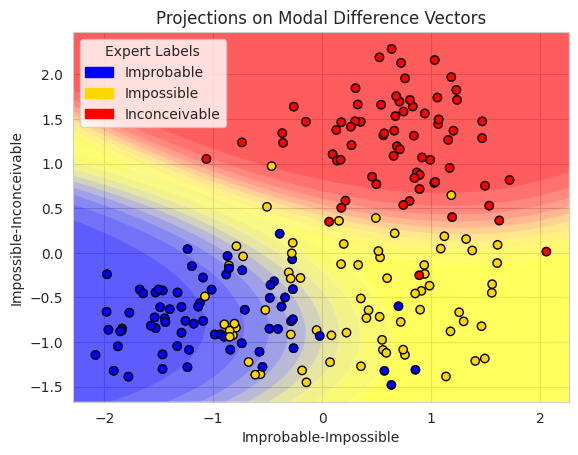

In [14]:
path = os.path.join("../results", "google/gemma-2-9b", "Calibration", "hu_shades/data", "Linear_Representation.csv")
data = pd.read_csv(path)
plot_shades_qda(data, ["improbable_impossible", "impossible_inconceivable"])

Someone lit a candle using a blowtorch.
[-1.77849932 -1.38846068]... 0.2702702702702703,0.7297297297297297,0.0,0.0

Someone built a house out of grass.
[-0.47325087 -0.35990382].... 0.0,0.6521739130434783,0.34782608695652173,0.0

Someone cleaned a carpet using a hat.
[ 0.85646864 -1.31085759]... 0.0,0.5121951219512195,0.3902439024390244,0.0975609756097561